# CProp with FP16

In [1]:
import tensorflow as tf
from cprop_tf.cprop import CProp

In [2]:
devices = tf.config.experimental.list_physical_devices('GPU')
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.config.experimental.set_memory_growth(devices[0], True)

In [4]:
from tensorflow.keras import backend as K

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [7]:
def make_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [72]:
def run(use_cprop, use_fp16, adam_eps, cprop_eps=None, epochs=10):
    if use_fp16:
        K.set_floatx('float16')
    else:
        K.set_floatx('float32')
        
    opt = tf.keras.optimizers.Adam(lr=1e-3, epsilon=adam_eps)
    if use_cprop:
        opt = CProp(opt, beta=0.999, c=1, cdf='bft', eps=cprop_eps)

    model = make_model()
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model.fit(train_images,
                     train_labels,
                     epochs=epochs,
                     validation_data=(test_images, test_labels))

In [9]:
history = {}

## Search eps for Adam (1e-3)

In [23]:
for eps in [1e-3, 1e-4, 1e-5]:
    history[f'fp16eps{eps}'] = [run(False, True, eps, epochs=5) for i in range(3)]

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 6s 114us/sample - loss: 1.5631 - acc: 0.4199 - val_loss: 1.2688 - val_acc: 0.5479
Epoch 2/5
50000/50000 [==============================] - 5s 106us/sample - loss: 1.1328 - acc: 0.5625 - val_loss: 1.1109 - val_acc: 0.6123
Epoch 3/5
50000/50000 [==============================] - 5s 106us/sample - loss: 0.9596 - acc: 0.6260 - val_loss: 0.9653 - val_acc: 0.6650
Epoch 4/5
50000/50000 [==============================] - 5s 105us/sample - loss: 0.8465 - acc: 0.6855 - val_loss: 0.9117 - val_acc: 0.6836
Epoch 5/5
50000/50000 [==============================] - 5s 105us/sample - loss: 0.7694 - acc: 0.7456 - val_loss: 0.8867 - val_acc: 0.6929
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 6s 115us/sample - loss: 1.6344 - acc: 0.3972 - val_loss: 1.3147 - val_acc: 0.5337
Epoch 2/5
50000/50000 [==============================] - 5s 106us/

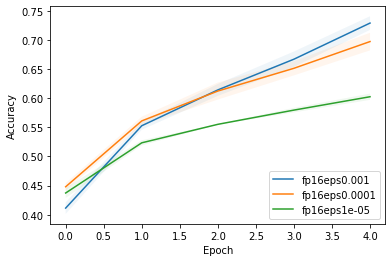

In [65]:
for eps in [1e-3, 1e-4, 1e-5]:
    x = np.array([
        history[f'fp16eps{eps}'][i].history['acc'] for i in range(3) 
    ])
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    plt.plot(range(len(mean)), mean, label=f'fp16eps{eps}')
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.07)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

## Search eps for Cprop (1e-4)

Based on adam's eps 1e-3. Turns out Adam's eps and Cporop's eps are quite different.

In [73]:
for eps in [1e-3, 1e-4, 1e-5]:
    history[f'cprop16eps{eps}'] = [run(True, True, 1e-3, eps, epochs=5) for i in range(3)]

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 12s 232us/sample - loss: 1.6964 - acc: 0.3877 - val_loss: 1.4461 - val_acc: 0.4749
Epoch 2/5
50000/50000 [==============================] - 10s 191us/sample - loss: 1.3353 - acc: 0.5078 - val_loss: 1.2833 - val_acc: 0.5430
Epoch 3/5
50000/50000 [==============================] - 10s 191us/sample - loss: 1.1749 - acc: 0.5488 - val_loss: 1.1332 - val_acc: 0.5952
Epoch 4/5
50000/50000 [==============================] - 10s 191us/sample - loss: 1.0584 - acc: 0.5850 - val_loss: 1.0427 - val_acc: 0.6304
Epoch 5/5
50000/50000 [==============================] - 10s 191us/sample - loss: 0.9661 - acc: 0.6240 - val_loss: 0.9829 - val_acc: 0.6567
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 12s 238us/sample - loss: 1.7444 - acc: 0.3691 - val_loss: 1.4699 - val_acc: 0.4641
Epoch 2/5
50000/50000 [==============================] - 10s

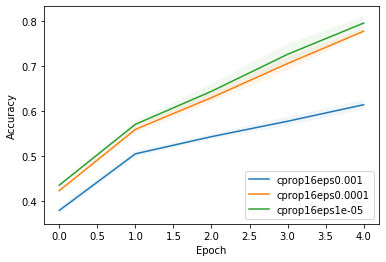

In [74]:
for eps in [1e-3, 1e-4, 1e-5]:
    x = np.array([
        history[f'cprop16eps{eps}'][i].history['acc'] for i in range(3) 
    ])
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    plt.plot(range(len(mean)), mean, label=f'cprop16eps{eps}')
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.07)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

## FP16 vs FP32

In [57]:
history['fp16'] = run(False, True, 1e-3)
history['fp32'] = run(False, False, 1e-3)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 136us/sample - loss: 1.5989 - acc: 0.4170 - val_loss: 1.2840 - val_acc: 0.5317
Epoch 2/10
50000/50000 [==============================] - 6s 121us/sample - loss: 1.1695 - acc: 0.5532 - val_loss: 1.0652 - val_acc: 0.6255
Epoch 3/10
50000/50000 [==============================] - 6s 120us/sample - loss: 0.9991 - acc: 0.6079 - val_loss: 1.0056 - val_acc: 0.6426
Epoch 4/10
50000/50000 [==============================] - 6s 119us/sample - loss: 0.8870 - acc: 0.6587 - val_loss: 0.9127 - val_acc: 0.6836
Epoch 5/10
50000/50000 [==============================] - 6s 120us/sample - loss: 0.7972 - acc: 0.7285 - val_loss: 0.9112 - val_acc: 0.6870
Epoch 6/10
50000/50000 [==============================] - 6s 120us/sample - loss: 0.7297 - acc: 0.7783 - val_loss: 0.8894 - val_acc: 0.6968
Epoch 7/10
50000/50000 [==============================] - 6s 120us/sample - loss: 0.6695 - acc: 0.8125 - val_l

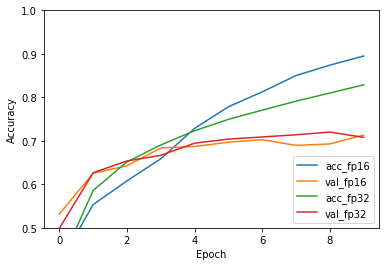

In [66]:
for name in ['fp16', 'fp32']:
    plt.plot(history[name].history['acc'], label=f'acc_{name}')
    plt.plot(history[name].history['val_acc'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
plt.savefig('cifar10.png')

## CPROP with FP16

In [75]:
history['cprop16'] = run(True, True, 1e-3, 1e-5)
history['cprop32'] = run(True, False, 1e-3, 1e-5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 268us/sample - loss: 1.5460 - acc: 0.4280 - val_loss: 1.2470 - val_acc: 0.5474
Epoch 2/10
50000/50000 [==============================] - 11s 214us/sample - loss: 1.1340 - acc: 0.5586 - val_loss: 1.0514 - val_acc: 0.6328
Epoch 3/10
50000/50000 [==============================] - 11s 212us/sample - loss: 0.9597 - acc: 0.6230 - val_loss: 0.9592 - val_acc: 0.6631
Epoch 4/10
50000/50000 [==============================] - 11s 213us/sample - loss: 0.8341 - acc: 0.7056 - val_loss: 0.8690 - val_acc: 0.6968
Epoch 5/10
50000/50000 [==============================] - 11s 212us/sample - loss: 0.7339 - acc: 0.7744 - val_loss: 0.8241 - val_acc: 0.7100
Epoch 6/10
50000/50000 [==============================] - 11s 213us/sample - loss: 0.6527 - acc: 0.8228 - val_loss: 0.8369 - val_acc: 0.7114
Epoch 7/10
50000/50000 [==============================] - 11s 213us/sample - loss: 0.5916 - acc: 0.8657 

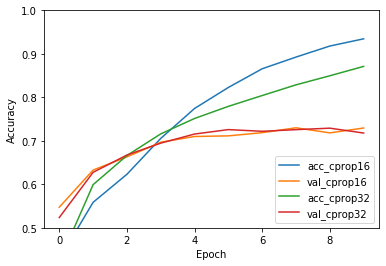

In [76]:
for name in ['cprop16', 'cprop32']:
    plt.plot(history[name].history['acc'], label=f'acc_{name}')
    plt.plot(history[name].history['val_acc'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
plt.savefig('cifar10.png')

## Adam vs CPROP

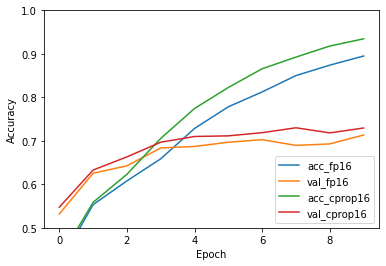

In [77]:
for name in ['fp16', 'cprop16']:
    plt.plot(history[name].history['acc'], label=f'acc_{name}')
    plt.plot(history[name].history['val_acc'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
plt.savefig('cifar10.png')

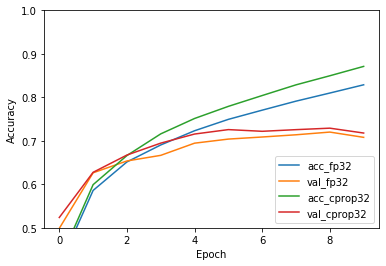

In [78]:
for name in ['fp32', 'cprop32']:
    plt.plot(history[name].history['acc'], label=f'acc_{name}')
    plt.plot(history[name].history['val_acc'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
plt.savefig('cifar10.png')